In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from IPython.display import display

from src.data_loader import read_dataset, get_loader
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization
import numpy as np

In [2]:
class FaceRecognitionCNN(nn.Module):
    def __init__(self):
        super(FaceRecognitionCNN, self).__init__()
        self.resnet = InceptionResnetV1(pretrained='vggface2')
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 1)

    def forward(self, images):
        out = self.resnet(images)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out.squeeze()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
model_dir = '/home/nika/Desktop/DeepFaceForgeryDetection/cloud_models/Jan11_20-35-47_gpu-training/'

In [5]:
model = FaceRecognitionCNN()
state_dict = torch.load(os.path.join(model_dir, 'model.pt'), map_location=device)
model.load_state_dict(state_dict)
model.eval();

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

In [19]:
_, val_dataset = read_dataset(
    '/home/nika/Desktop/FaceForensics/original', '/home/nika/Desktop/FaceForensics/neural_textures/',
    transform=transform, max_images_per_video=1, splits_path='dataset/splits', window_size=1
)

print(f'validation data size: {len(val_dataset)}')

val_loader = get_loader(
    val_dataset, batch_size=32, shuffle=True, num_workers=4
)

validation data size: 210


In [7]:
all_predictions = []
all_targets = []
all_video_ids = []

with torch.no_grad():
    for video_ids, images, targets in tqdm(val_loader):
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        predictions = outputs > 0.0
        all_predictions.append(predictions)
        all_targets.append(targets)
        all_video_ids.append(video_ids)

all_predictions = torch.cat(all_predictions)
all_targets = torch.cat(all_targets)
all_video_ids = torch.cat(all_video_ids)

In [8]:
all_predictions.shape

torch.Size([1056])

In [9]:
(all_predictions[1:] == all_predictions[:-1]).sum().float() / all_predictions.shape[0]

tensor(0.6354)

In [10]:
set(all_video_ids.tolist())

{1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 272396,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 221206,
 25,
 763930,
 27,
 133148,
 217117,
 30,
 31,
 32,
 28,
 34,
 33,
 37,
 40997,
 38,
 40,
 39,
 41,
 43,
 403497,
 45,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 577593,
 58,
 59,
 60,
 61,
 62,
 63,
 57,
 65,
 66,
 67,
 796740,
 69,
 70,
 68,
 72,
 983113,
 74,
 75,
 76,
 77,
 86090,
 264271,
 80,
 79,
 82,
 81,
 655444,
 85,
 86,
 87,
 88,
 89,
 83,
 311387,
 213083,
 886877,
 93,
 94,
 931936,
 97,
 522337,
 99,
 100,
 101,
 43110,
 103,
 95,
 41063,
 98,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 105,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 209016,
 125,
 753789,
 839,
 127,
 475265,
 130,
 131,
 51332,
 132,
 618629,
 129,
 136,
 751752,
 137,
 139,
 133,
 140,
 143,
 144,
 884968,
 146,
 147,
 148,
 149,
 39058,
 151,
 150,
 153,
 127129,
 155,
 156,
 262301,
 152,
 160,
 598178,
 163,
 164,
 165,
 166,
 167,
 168,
 215208,
 307365,
 162,
 171,
 173,
 174,
 172,
 32944,
 177,
 17

In [11]:
# All misclassified video ids
set(all_video_ids[~(all_predictions == all_targets)].tolist())

{130,
 137,
 143,
 150,
 160,
 206,
 207,
 211,
 236,
 248,
 251,
 276,
 331,
 398,
 414,
 430,
 476,
 532,
 602,
 659,
 696,
 737,
 757,
 790,
 819,
 840,
 918,
 936,
 983,
 18019,
 33097,
 41063,
 43110,
 57070,
 61080,
 62066,
 65089,
 69961,
 71054,
 95053,
 105180,
 118120,
 123119,
 124085,
 133148,
 136285,
 146256,
 152149,
 173171,
 191188,
 194235,
 195442,
 197224,
 199181,
 201203,
 202348,
 211177,
 213083,
 215208,
 222168,
 229247,
 242182,
 244822,
 259345,
 262301,
 264271,
 268269,
 286267,
 290240,
 297270,
 304300,
 305513,
 311387,
 312021,
 313283,
 318334,
 320328,
 341340,
 344020,
 360437,
 361448,
 374407,
 391406,
 392339,
 393405,
 401395,
 403497,
 409382,
 415484,
 431447,
 439441,
 451449,
 456435,
 478506,
 500592,
 504502,
 508831,
 510528,
 522337,
 535587,
 536540,
 537563,
 542520,
 543559,
 544532,
 561998,
 577593,
 582172,
 590034,
 598178,
 604703,
 609596,
 611760,
 614616,
 621546,
 624570,
 631551,
 636578,
 637427,
 645688,
 646643,
 652773,


In [12]:
all_predictions.shape, all_targets.shape

(torch.Size([1056]), torch.Size([1056]))

In [13]:
confusion_matrix(all_predictions, all_targets)

array([[672, 131],
       [ 29, 224]])

In [14]:
tn, fp, fn, tp = confusion_matrix(all_predictions, all_targets).ravel()
tn, fp, fn, tp

(672, 131, 29, 224)

In [15]:
total = float(tn + fp + fn + tp)
accuracy = (tp + tn) / total
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('accuracy', accuracy)
print('precision', precision)
print('recall', recall)

accuracy 0.8484848484848485
precision 0.6309859154929578
recall 0.8853754940711462


In [16]:
# original accuracy, 
tn / (tn + fp)

0.8368617683686177

In [17]:
# neural textures accuracy
tp / (tp + fn)

0.8853754940711462

In [18]:
# overall accuracy
(tn + tp) / (tp + tn + fp + fn)

0.8484848484848485

In [16]:
incorrect_labels = []
for index, (pred, target) in enumerate(zip(all_predictions, all_targets)):
    if pred != target:
        incorrect_labels.append((index, pred, target))

In [56]:
all_targets

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [55]:
all_predictions.int()

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)

In [24]:
_, val_dataset = read_dataset(
    'dataset/images_large/original', 'dataset/images_large/tampered', transform=None,
    max_images_per_video=999999, splits_path='dataset/splits'
)

def display_sample(label_index):
    img_index, pred, target = incorrect_labels[label_index]
    print('label_index: {}, pred: {}, target: {}'.format(label_index, pred, target))
    return val_dataset[img_index][0]

In [ ]:
display(*[x[0] for x in val_dataset][:-100])

In [73]:
y_pred = torch.Tensor([0])
y_true = torch.Tensor([1.])
nn.BCELoss()(y_pred, y_true)

tensor(27.6310)

$$
        \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]
$$

In [33]:
images.shape, targets.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [34]:
targets

tensor([0.])

In [62]:
with torch.no_grad():
    scores = model(images)

In [44]:
nn.Sigmoid()(scores)

tensor(0.0183)

In [45]:
img = images[0]

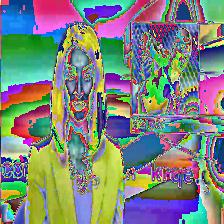

In [46]:
reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.ToPILImage()
])


transforms.ToPILImage()(img)